# Korean Drama Data Preprocessing
* Analyze which features/metrics show statistical significance
* Clean and combine everything for modeling

## Metrics to measure
* Genre by rating
* Genre by watchers
* Watchers and genre by year
* Rating by number of episodes
* Watchers by number of episodes
* Rating by duration of episode
* Watchers by duration of episode
* Tags by rating
* Tags by watchers
* Tags by year
* Most frequent cast name
* Cast by genre
* Cast by rating
* Cast by watchers
* Cast by tags

In [1]:
# Modules that will be used
import pandas as pd
import numpy as np
import re
import textwrap
import matplotlib.pyplot as plt 
import seaborn as sns 
from scipy.stats import f_oneway
from scipy.stats import pearsonr
from scipy.stats import chi2_contingency
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [2]:
# Load Korean drama datasets
files = [
    pd.read_csv('data/kdrama/top100_kdrama.csv'),
    pd.read_csv('data/kdrama/top100_most.csv'),
    pd.read_csv('data/kdrama/kdrama.csv'),
    pd.read_csv('data/kdrama/korean_drama.csv'),
    pd.read_csv('data/kdrama/kdrama_DATASET.csv'),
    pd.read_csv('data/kdrama/reviews.csv'),
    pd.read_csv('data/kdrama/wiki_actors.csv')
]

# Standardize column names
for i in range(len(files)):
    files[i].columns = files[i].columns.str.strip().str.title()

# Combine all data into one DataFrame
drama_combined = pd.concat(files, ignore_index=True)

desired_order = ['Title', 'Rating', 'Genres', 'Rank', 'Year', 'Air Date', 'Episodes', 'Duration', 'Watchers', 'Tags', 'Synopsis', 'Cast', 'Network', 'Review']

# Fill any missing columns with NaN
for col in desired_order:
    if col not in drama_combined.columns:
        drama_combined[col] = np.nan

drama_combined = drama_combined[desired_order]

drama_combined

,Title,Rating,Genres,Rank,Year,Air Date,Episodes,Duration,Watchers,Tags,Synopsis,Cast,Network,Review
0,Move to Heaven,9.2,"Life, Drama",8,NaN,5/14/2021,10.0,NaN,"64,103","Uncle-Nephew Relationship, Autism, Death, Sava...",Han Geu Roo is a 20-year-old with Autism. He w...,"Lee Je Hoon, Tang Jun Sang, Hong Seung Hee",NaN,NaN
1,Weak Hero Class 1,9.1,"Action, Youth, Drama",12,NaN,11/18/2022,8.0,NaN,"32,415","Smart Male Lead, Bromance, School Bullying, Vi...",Yeon Shi Eun is a model student who ranks at t...,"Park Ji Hoon, Hong Kyung, Choi Hyun Wook, Kim ...",NaN,NaN
2,Hospital Playlist Season 2,9.1,"Romance, Life, Drama, Medical",14,NaN,6/17/2021,12.0,NaN,"43,574","Multiple Mains, Band, Music, Strong Female Lea...",Everyday is extraordinary for five doctors and...,"Jo Jung Suk, Jung Kyung Ho, Jeon Mi Do, Yoo Ye...",NaN,NaN
3,Flower of Evil,9.1,"Thriller, Romance, Crime, Melodrama",16,NaN,7/29/2020,16.0,NaN,"94,811","Deception, Family Secret, Mystery, Suspense, S...",Although Baek Hee Sung is hiding a dark secret...,"Lee Joon Gi, Jang Hee Jin, Moon Chae Won, Seo ...",NaN,NaN
4,Hospital Playlist,9.1,"Romance, Life, Drama, Medical",17,NaN,3/12/2020,12.0,NaN,"81,568","Nice Male Lead, Multiple Mains, Slow Romance, ...",The stories of people going through their days...,"Jo Jung Suk, Jung Kyung Ho, Jeon Mi Do, Yoo Ye...",NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21831,Heart to Heart,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Lee Moon Jung,NaN,NaN
21832,"Kill Me, Heal Me",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Kim Young Ae,NaN,NaN
21833,Enchanting Neighbor,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Park Tam Hee,NaN,NaN
21834,Iron Lady Cha,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Shin Min Soo,NaN,NaN


In [3]:
# Merge similar values and drop any duplciates
def merge_and_deduplicate(values):
    all_items = []
    for val in values.dropna():
        parts = re.split(r'[,/;]', val)
        all_items.extend([p.strip() for p in parts if p.strip()])
    
    unique_items = sorted(set(all_items))
    return ', '.join(unique_items) if unique_items else np.nan

In [4]:
# Data cleaning: Format any strings to numerical values

# Convert shorthand numbers to integers
def convert_shorthand_number(x):
    if pd.isna(x):
        return None 
    if isinstance(x, (int, float)):
        return x
    x = str(x).replace(",", "").strip().upper()
    match = re.match(r"([\d\.]+)([KM]?)", x)
    if not match:
        return None 
    number, suffix = match.groups()
    number = float(number)
    if suffix == 'K':
        return int(number * 1_000)
    elif suffix == 'M':
        return int(number * 1_000_000)
    return int(number)

# Extract year from air date string
def extract_year(x):
    if pd.isna(x):
        return np.nan 
    match = re.search(r'\d{4}', str(x))
    return int(match.group()) if match else np.nan  

# Convert duration to minutes
def duration_to_minutes(x):
    if pd.isna(x):
        return np.nan 
    x = str(x).lower()
    if ':' in x: # For data with "1:10" formats
        parts = x.split(':')
        if len(parts) == 2 and all(p.isdigit() for p in parts):
            return int(parts[0]) * 60 + int(parts[1])
    # Format like "1hr 15min"
    hr_match = re.search(r'(\d+)\s*hr', x)
    min_match = re.search(r'(\d+)\s*min', x)
    hours = int(hr_match.group(1)) if hr_match else 0
    minutes = int(min_match.group(1)) if min_match else 0 
    if hours or minutes:
        return hours * 60 + minutes 
    return np.nan 

In [5]:
# Apply transformations to relevant columns
drama_combined['Air Date'] = drama_combined['Air Date'].apply(extract_year)
drama_combined['Watchers'] = drama_combined['Watchers'].apply(convert_shorthand_number)
drama_combined['Duration'] = drama_combined['Duration'].apply(duration_to_minutes)

In [6]:
# Combine duplicate titles
agg_funcs = {
    'Rating': lambda x: round(x.dropna().astype(float).mean(), 2) if not x.dropna().empty else np.nan,
    'Genres': merge_and_deduplicate,
    'Rank': 'first',
    'Year': lambda x: int(x.dropna().max()) if not x.dropna().empty else np.nan,
    'Air Date': 'first',
    'Episodes': lambda x: int(x.dropna().max()) if not x.dropna().empty else np.nan, 
    'Duration': lambda x: int(x.dropna().mean()) if not x.dropna().empty else np.nan,
    'Watchers': lambda x: int(x.dropna().max()) if not x.dropna().empty else np.nan,
    'Tags': merge_and_deduplicate,
    'Synopsis': 'first',
    'Cast': merge_and_deduplicate,
    'Network': 'first',
    'Review': 'first'
}

# Group by title and aggregate
drama_combined = drama_combined.groupby('Title', as_index=False).agg(agg_funcs)

# Reorder columns again just in case
drama_combined = drama_combined[desired_order]

# Check
drama_combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1977 entries, 0 to 1976
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Title     1977 non-null   object 
 1   Rating    478 non-null    float64
 2   Genres    478 non-null    object 
 3   Rank      1963 non-null   object 
 4   Year      1895 non-null   float64
 5   Air Date  1890 non-null   float64
 6   Episodes  1977 non-null   int64  
 7   Duration  287 non-null    float64
 8   Watchers  196 non-null    float64
 9   Tags      478 non-null    object 
 10  Synopsis  1795 non-null   object 
 11  Cast      1870 non-null   object 
 12  Network   1407 non-null   object 
 13  Review    1278 non-null   object 
dtypes: float64(5), int64(1), object(8)
memory usage: 216.4+ KB


In [7]:
drama_combined

,Title,Rating,Genres,Rank,Year,Air Date,Episodes,Duration,Watchers,Tags,Synopsis,Cast,Network,Review
0,100 Days My Prince,8.30,"Comedy, Drama, Historical, Romance",#187,2018.0,2018.0,16,75.0,NaN,"Amnesia, Double Identity, Eccentric Male Lead,...","Lee Yul, Crown Prince of Joseon, is a perfecti...","Doh Kyung Soo, Han So Hee, Jo Sung Ha, Kim Jae...",tvN,"As a valid fan of the actor Kyungsoo, I had to..."
1,100% Era,NaN,NaN,5532,2021.0,2021.0,8,NaN,NaN,NaN,100% Era imagines the post-corona future. How ...,"Lee Seung Yeon, Lee Soo Min, Logan, Pyun Kang ...",None,"Good Enough Korean Webdrama ""100% Era"" tries ..."
2,10000 Ways to Become a Couple,NaN,NaN,99999,2017.0,2017.0,5,NaN,NaN,NaN,‘Are we doing alright?’ From the first fight t...,NaN,None,None
3,109 Strange Things,NaN,NaN,8872,2017.0,2017.0,6,NaN,NaN,NaN,"When a robot comes from the future, will a phi...","Cho Yi Hyun, Choi Tae Joon, Jung Chae Yeon, K...",Naver TV Cast,I honestly went into this with low expectation...
4,18 Again,8.67,"Drama, Fantasy, Life, Romance",203,2020.0,2020.0,16,70.0,83582.0,"Becoming Young, Character Development, Divorce...","After nearly twenty years of marriage, Jung Da...","Kim Ha Neul, Lee Do Hyun, Roh Jeong Eui, Ryeou...",jTBC,Beautiful moments surrounded by nothing. Her...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1972,Yumi's Cells 2,8.40,"Comedy, Life, Romance",#169,2022.0,2022.0,14,65.0,NaN,"Adapted From A Webtoon, Illustrator Supporting...","After suffering a painful breakup, Yu Mi’s lov...","Ahn Bo Hyun, Kim Go Eun, Kwon Seung Woo, Lee Y...",tvN,None
1973,Yumi's Cells Season 2,NaN,NaN,815,2022.0,2022.0,14,NaN,NaN,NaN,"After suffering a painful breakup, Yu Mi’s lov...","Ahn Bo Hyun, Kim Go Eun, Kwon Seung Woo, Lee Y...",TVING,Everybody loves Yumi... including Yumi This d...
1974,Yunseul,NaN,NaN,99999,2021.0,2021.0,5,NaN,NaN,NaN,"Yunseul is about a story that transcends 1,500...",NaN,None,None
1975,Zero Ability for Dating,NaN,NaN,62603,2021.0,2021.0,10,NaN,NaN,NaN,Among 7.9 billion people in the world. Where i...,NaN,None,None


In [8]:
drama_combined.to_csv("data/combined/not-clean/drama_combined.csv", index=False)

In [9]:
# Load combined raw drama data
df = pd.read_csv('data/combined/not-clean/drama_combined.csv')

In [10]:
# Keep only the relevant columns
df_genre = df[['Genres', 'Rating']].dropna()

# Split genres into multiple rows (if genres are comma-separated)
df_genre = df_genre.assign(Genres=df_genre['Genres'].str.lower()) # normalize case
df_genre = df_genre.assign(Genres=df_genre['Genres'].str.split(','))
df_genre = df_genre.explode('Genres')
df_genre['Genres'] = df_genre['Genres'].str.strip()

In [11]:
df_genre

,Genres,Rating
0,comedy,8.30
0,drama,8.30
0,historical,8.30
0,romance,8.30
4,drama,8.67
...,...,...
1971,psychological,8.50
1971,romance,8.50
1972,comedy,8.40
1972,life,8.40


/var/folders/9d/qf8c_y4j6p92qbpr3js013zm0000gn/T/ipykernel_4015/2519762205.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=genre_rating_filtered.values, y=genre_rating_filtered.index, palette='viridis')


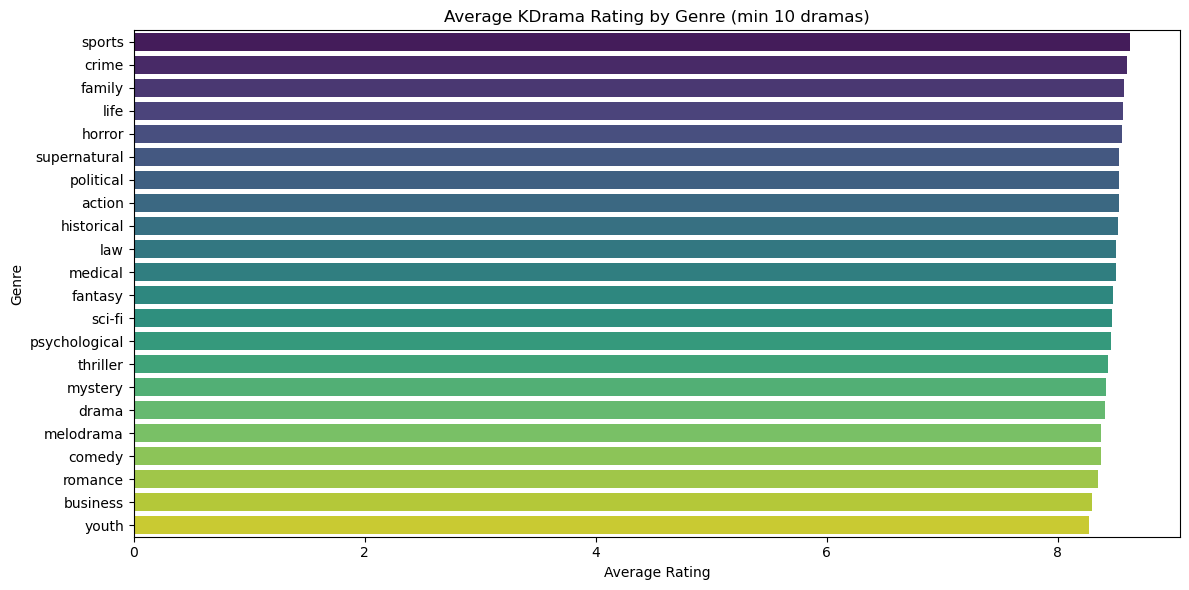

In [12]:
# Genre vs rating

# Group by genre and compute average rating
genre_rating = df_genre.groupby('Genres')['Rating'].mean().sort_values(ascending=False)
genre_count = df_genre['Genres'].value_counts()

# Filter for genres with a minimum count for reliability. In this case, only include genres that appear in at least 10 dramas
# This will exclude uncommon genres that appear less than 10 times across the data
reliable_genres = genre_count[genre_count >= 10].index
genre_rating_filtered = genre_rating[genre_rating.index.isin(reliable_genres)]

# Plot the bar graph
plt.figure(figsize=(12, 6))
sns.barplot(x=genre_rating_filtered.values, y=genre_rating_filtered.index, palette='viridis')
plt.xlabel('Average Rating')
plt.ylabel('Genre')
plt.title('Average KDrama Rating by Genre (min 10 dramas)')
plt.tight_layout()
plt.show() 

In [13]:
# Genre vs rating statistical significance
groups = [group['Rating'].values for name, group in df_genre[df_genre['Genres'].isin(reliable_genres)].groupby('Genres')]

f_stat, p_value = f_oneway(*groups)
print(f"ANOVA F-statistic: {f_stat:.2f}, p-value: {p_value:.4f}")

ANOVA F-statistic: 2.62, p-value: 0.0001


There is statistical significance of high rating and popular genres

In [14]:
# Most popular genres based on number of watchers
df_watchers = df[['Genres', 'Watchers']].dropna()
df_watchers['Genres'] = df_watchers['Genres'].str.lower().str.split(',')
df_watchers = df_watchers.explode('Genres')
df_watchers['Genres'] = df_watchers['Genres'].str.strip()

In [15]:
df_watchers

,Genres,Watchers
4,drama,83582.0
4,fantasy,83582.0
4,life,83582.0
4,romance,83582.0
31,comedy,99264.0
...,...,...
1955,romance,93683.0
1966,drama,42475.0
1966,melodrama,42475.0
1966,romance,42475.0


/var/folders/9d/qf8c_y4j6p92qbpr3js013zm0000gn/T/ipykernel_4015/1262594805.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=genre_watchers_sorted.values, y=genre_watchers_sorted.index, palette='coolwarm', order=genre_watchers_sorted.index)


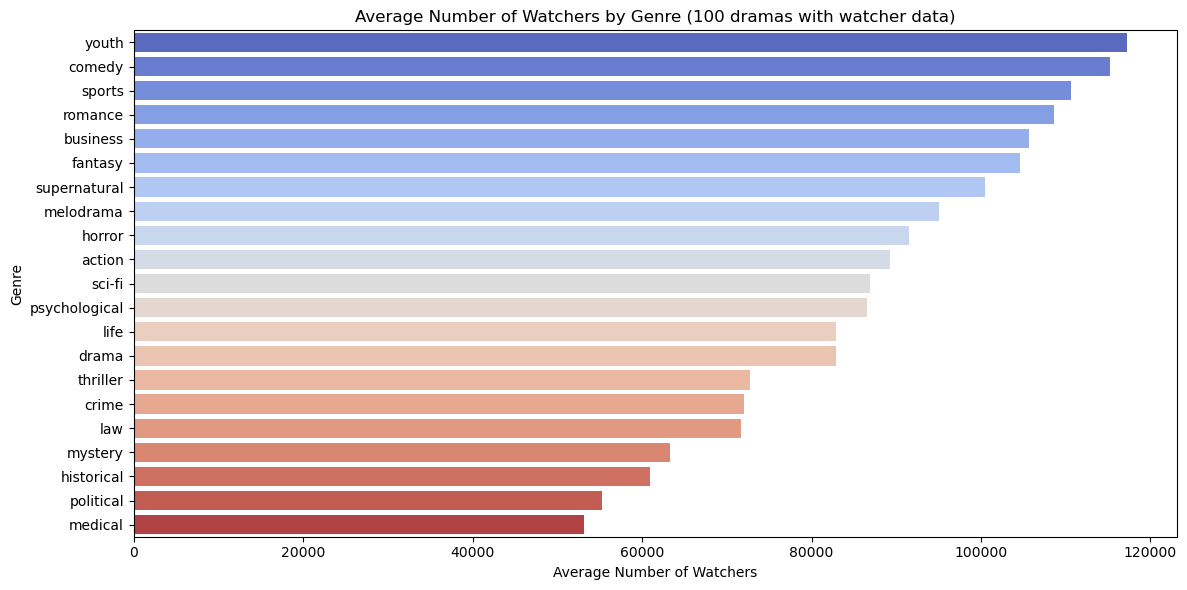

In [16]:
# Genre vs average number of watchers
genre_watchers = df_watchers.groupby('Genres')['Watchers'].mean()

# Filter genres with at least 5 dramas
genre_counts = df_watchers['Genres'].value_counts()
reliable_genres = genre_counts[genre_counts >= 5].index 
genre_watchers_filtered = genre_watchers[genre_watchers.index.isin(reliable_genres)]

# Sort by average number of watchers (descending)
genre_watchers_sorted = genre_watchers_filtered.sort_values(ascending=False)

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(x=genre_watchers_sorted.values, y=genre_watchers_sorted.index, palette='coolwarm', order=genre_watchers_sorted.index)

plt.xlabel('Average Number of Watchers')
plt.ylabel('Genre')
plt.title('Average Number of Watchers by Genre (100 dramas with watcher data)')
plt.tight_layout()
plt.show()

In [17]:
# Genre vs watchers statistical signficance

# Filter genres that appear enough times (disregard any uncommon genres)
genre_count = df_watchers['Genres'].value_counts()
reliable_genres = genre_counts[genre_counts >= 5].index 
df_reliable = df_watchers[df_watchers['Genres'].isin(reliable_genres)]

# Group watchers by genre
groups = [group['Watchers'].values for name, group in df_reliable.groupby('Genres')]

# ANOVA test
f_stat, p_value = f_oneway(*groups)
print(f"ANOVA F-statistic: {f_stat:.2f}, p-value: {p_value:.4f}")

ANOVA F-statistic: 4.49, p-value: 0.0000


There is statistical significance of genre and number of watchers

/var/folders/9d/qf8c_y4j6p92qbpr3js013zm0000gn/T/ipykernel_4015/1105116453.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_top_genres, x='Rating', y='Genres', palette='coolwarm')


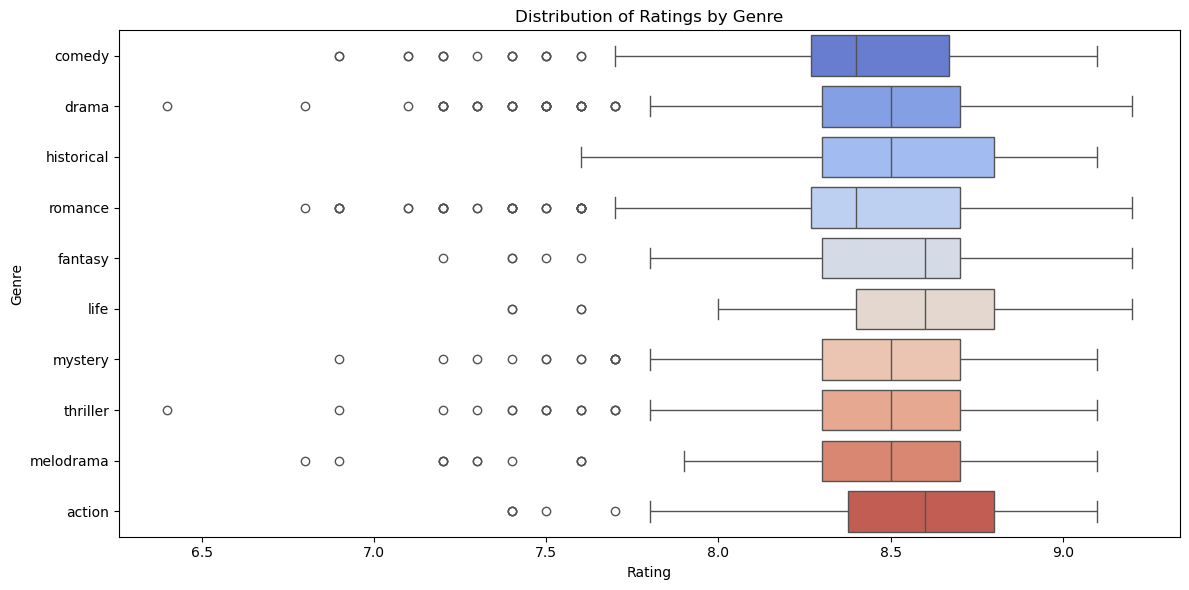

In [18]:
# Visualize rating and watchers by genre

# Explode genres
df_genres_watchers = df[['Genres', 'Rating', 'Watchers']].dropna(subset=['Genres', 'Rating'])
df_genres_watchers['Genres'] = df_genres_watchers['Genres'].str.lower().str.split(',')
df_genres_watchers = df_genres_watchers.explode('Genres')
df_genres_watchers['Genres'] = df_genres_watchers['Genres'].str.strip()

# Limit to top genres
top_genres = df_genres_watchers['Genres'].value_counts().head(10).index
df_top_genres = df_genres_watchers[df_genres_watchers['Genres'].isin(top_genres)]

# Rating by genre
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_top_genres, x='Rating', y='Genres', palette='coolwarm')
plt.title('Distribution of Ratings by Genre')
plt.xlabel('Rating')
plt.ylabel('Genre')
plt.tight_layout()
plt.show()

## Distribution of Ratings by Genre
* Action and thriller shows consistent high ratings and low variance. Among all the genres, they're the safest bets
* Melodrama, thriller and mystery have strong ratings, but have some low-rated titles
* Comedy has the wider spread and low-ratedo outliers. While it's popular, the plot shows it can be hit or miss
* Romance and fantasy seem to show broad appeal but the highest risk. Some titles have high ratings while others have low ratings
* Life is well-received but characterized by range of responses

/var/folders/9d/qf8c_y4j6p92qbpr3js013zm0000gn/T/ipykernel_4015/4012153470.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_top_genres, x='Watchers', y='Genres', palette='mako')


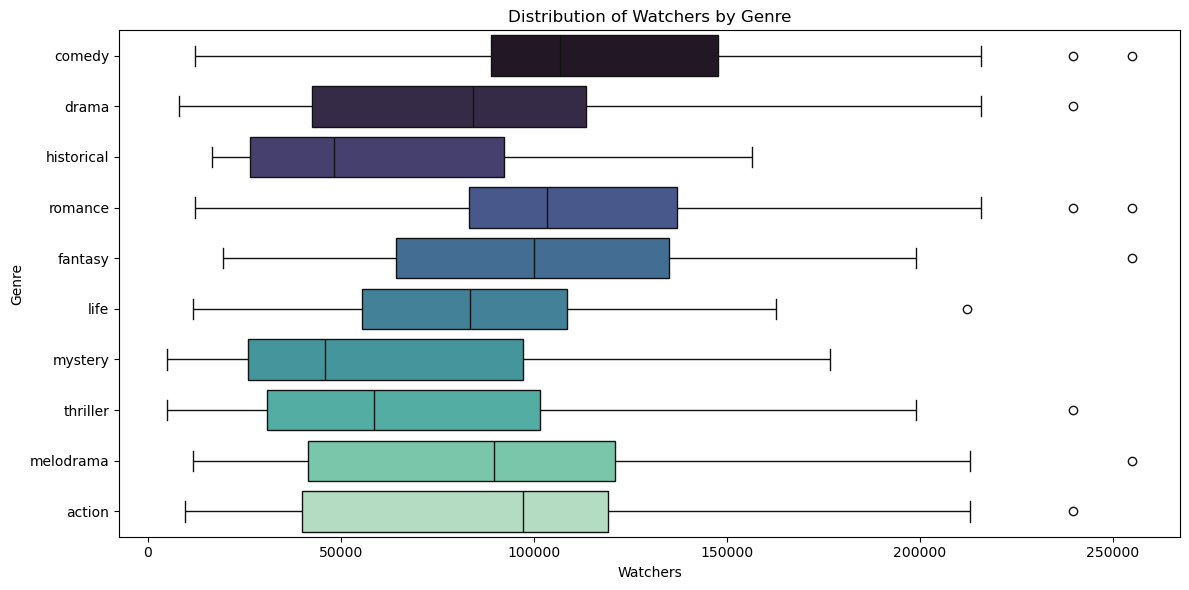

In [19]:
df_top_genres = df_top_genres.reset_index(drop=True)

plt.figure(figsize=(12, 6))
sns.boxplot(data=df_top_genres, x='Watchers', y='Genres', palette='mako')
plt.title('Distribution of Watchers by Genre')
plt.xlabel('Watchers')
plt.ylabel('Genre')
plt.tight_layout()
plt.show()

## Distribution of Watchers by Genre
* Romance and action genres have the highest-end outlier. This can be attributed to hit shows
* Thriller and melodrama are consistently strong in median watchers
* Thriller and actions draw higher watchers
* Comedy has more variability, but have lower viewer counts. No major outliers and long whiskers
* Life and fantasy show good performance, but are more variable
* Historical show moderate spread

/var/folders/9d/qf8c_y4j6p92qbpr3js013zm0000gn/T/ipykernel_4015/2996210766.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Year', y='Total_Watchers', data=summary, palette='crest')


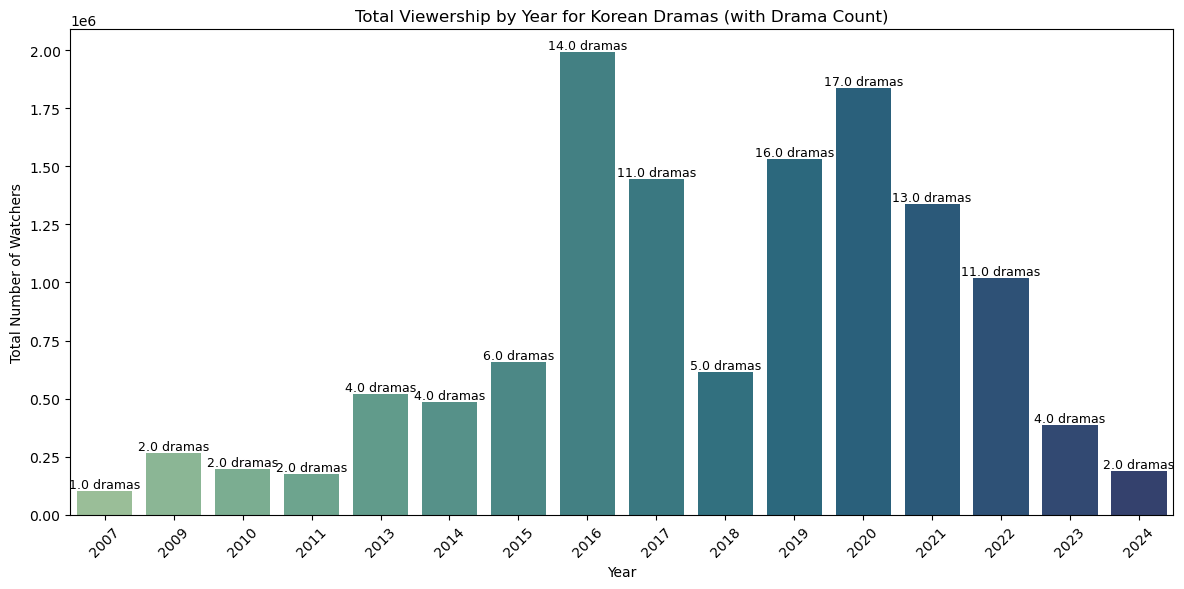

In [20]:
# Year vs watchers

df_year_watchers = df[['Year', 'Watchers']].dropna()
df_year_watchers['Year'] = df_year_watchers['Year'].astype(int)
summary = df_year_watchers.groupby('Year').agg(Total_Watchers=('Watchers', 'sum'), Drama_Count=('Watchers', 'count')).reset_index()

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(x='Year', y='Total_Watchers', data=summary, palette='crest')

# Label number of dramas per year
for index, row, in summary.iterrows():
    plt.text(
        x=index,
        y=row['Total_Watchers'],
        s=f"{row['Drama_Count']} dramas",
        ha='center',
        va='bottom',
        fontsize=9
    )

plt.xlabel("Year")
plt.ylabel("Total Number of Watchers")
plt.title("Total Viewership by Year for Korean Dramas (with Drama Count)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [21]:
# Popular genres based on year 
df_genre_year = df[['Year', 'Genres', 'Watchers']].dropna()

df_genre_year['Genres'] = df_genre_year['Genres'].str.lower().str.split(',')
df_genre_year = df_genre_year.explode('Genres')
df_genre_year['Genres'] = df_genre_year['Genres'].str.strip()

# Group by year and genre, then sum watchers
grouped = df_genre_year.groupby(['Year', 'Genres'])['Watchers'].sum().reset_index()

# Get the top genre(s) for each year
top_genres_by_year = grouped.sort_values(['Year', 'Watchers'], ascending=[True, False])
top_genres = top_genres_by_year.groupby('Year').first().reset_index()

print(top_genres)

      Year   Genres   Watchers
0   2007.0   comedy   104033.0
1   2009.0   comedy   263636.0
2   2010.0   comedy   198660.0
3   2011.0   action    91101.0
4   2013.0  romance   519960.0
5   2014.0  romance   485104.0
6   2015.0  romance   658764.0
7   2016.0  romance  1902862.0
8   2017.0  romance  1359235.0
9   2018.0  romance   529558.0
10  2019.0  romance  1357057.0
11  2020.0  romance  1471925.0
12  2021.0    drama  1134226.0
13  2022.0    drama   738921.0
14  2023.0  romance   302557.0
15  2024.0   comedy   187914.0


In [22]:
# Test if year and genre has statistical significance in the number of watchers
df_filtered = df_genre_year.dropna(subset=['Year', 'Genres', 'Watchers'])

# Run Two-Way ANOVA
model = ols('Watchers ~ C(Year) + C(Genres) + C(Year):C(Genres)', data=df_filtered).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 15, but rank is 9
  warnings.warn('covariance of constraints does not have full '
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 25, but rank is 17
  warnings.warn('covariance of constraints does not have full '
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 375, but rank is 1
  warnings.warn('covariance of constraints does not have full '


                         sum_sq     df             F    PR(>F)
C(Year)           -4.839434e+03   15.0 -1.432745e-07  1.000000
C(Genres)         -8.774016e+02   25.0 -1.558562e-08  1.000000
C(Year):C(Genres)  3.558922e+11  375.0  4.214565e-01  0.516757
Residual           6.147480e+11  273.0           NaN       NaN


No statistical significance is found of year and genre on the number of watchers

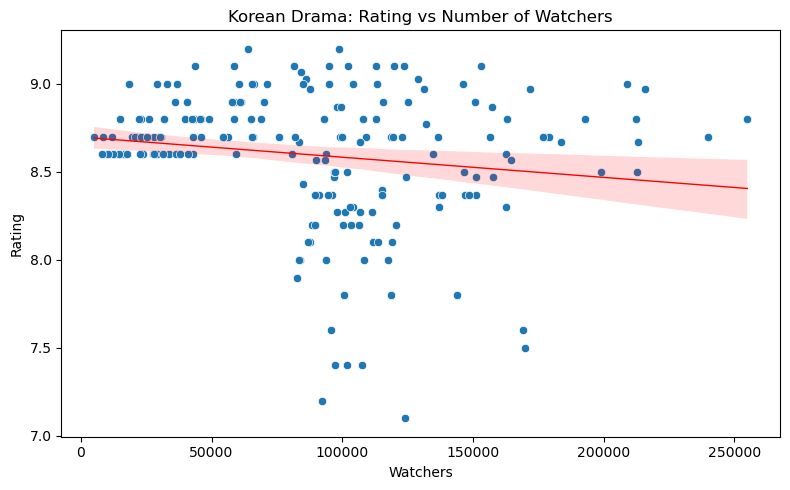

Pearson rating correlation: -0.16 (p = 0.0259)


In [58]:
# Correlation of watchers and rating
df_watch_rat = df[['Watchers', 'Rating']].dropna()

# Watchers vs rating scatterplot
plt.figure(figsize=(8, 5))
sns.scatterplot(data=df_watch_rat, x='Watchers', y='Rating')
sns.regplot(data=df_watch_rat, x='Watchers', y='Rating', scatter=False, color='red', line_kws={"linewidth": 1})
plt.title('Korean Drama: Rating vs Number of Watchers')
plt.xlabel('Watchers')
plt.ylabel('Rating')
plt.tight_layout()
plt.show()

# Correlation score: watchers vs rating
corr_rating, p_rating = pearsonr(df_watch_rat['Watchers'], df_watch_rat['Rating'])
print(f'Pearson rating correlation: {corr_rating:.2f} (p = {p_rating:.4f})')

In [24]:
# Analyze number of watchers and rating based on number of episodes
df_rating = df[['Episodes', 'Rating']].dropna()
df_watchers = df[['Episodes', 'Watchers']].dropna()

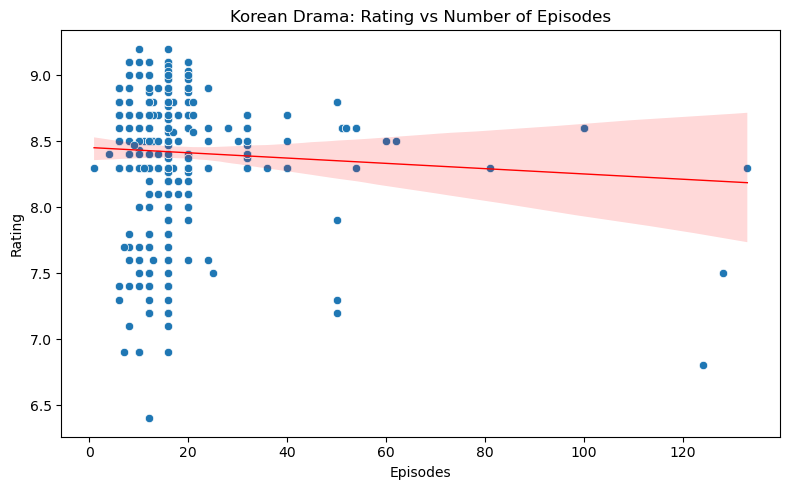

In [25]:
# Episodes vs rating scatterplot
plt.figure(figsize=(8, 5))
sns.scatterplot(data=df_rating, x='Episodes', y='Rating')
sns.regplot(data=df_rating, x='Episodes', y='Rating', scatter=False, color='red', line_kws={"linewidth": 1})
plt.title('Korean Drama: Rating vs Number of Episodes')
plt.xlabel('Episodes')
plt.ylabel('Rating')
plt.tight_layout()
plt.show()

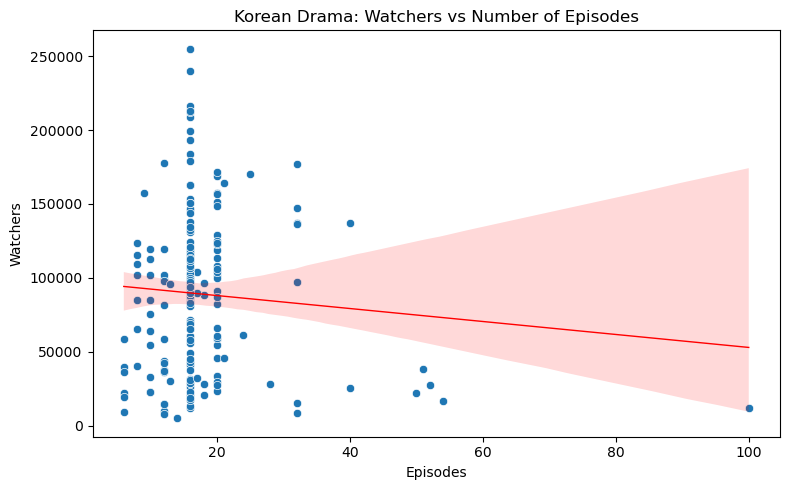

In [26]:
# Episodes vs watchers scatterplot
plt.figure(figsize=(8, 5))
sns.scatterplot(data=df_watchers, x='Episodes', y='Watchers')
sns.regplot(data=df_watchers, x='Episodes', y='Watchers', scatter=False, color='red', line_kws={"linewidth": 1})
plt.title('Korean Drama: Watchers vs Number of Episodes')
plt.xlabel('Episodes')
plt.ylabel('Watchers')
plt.tight_layout()
plt.show()

In [27]:
# Correlation score: episodes vs rating
corr_rating, p_rating = pearsonr(df_rating['Episodes'], df_rating['Rating'])
print(f'Rating correlation: {corr_rating:.2f} (p = {p_rating:.4f})')

# Correlation score: episodes vs watchers
corr_watchers, p_watchers = pearsonr(df_watchers['Episodes'], df_watchers['Watchers'])
print(f"Watchers correlation: {corr_watchers:.2f} (p = {p_watchers:.4f})")

Rating correlation: -0.06 (p = 0.1872)
Watchers correlation: -0.08 (p = 0.2783)


* For both rating and number of watchers, there is negative correlation indicating that more episodes may lead to decrease in engagement
* The p-value shows that the number of episodes do not have statistical signficance in rating and watchers

In [28]:
# Analyze episode duration (minutes) on rating and number of watchers 
df_duration_rating = df[['Duration', 'Rating']].dropna()
df_duration_watchers = df[['Duration', 'Watchers']].dropna()

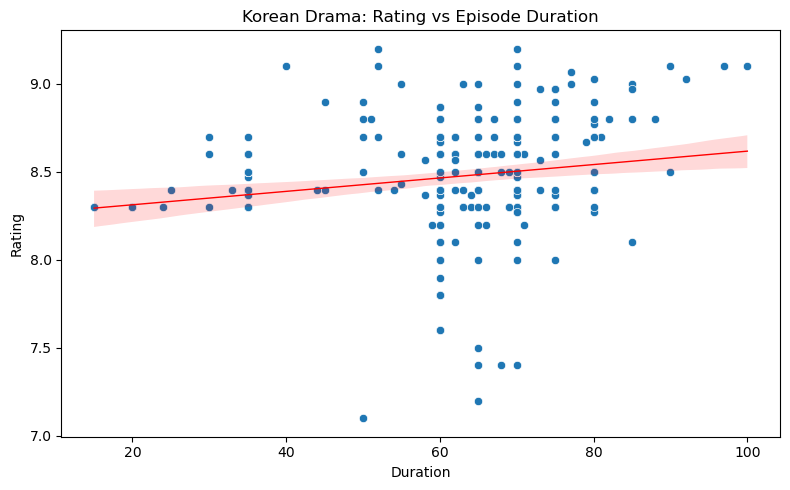

In [29]:
# Duration vs rating scatterplot
plt.figure(figsize=(8, 5))
sns.scatterplot(data=df_duration_rating, x='Duration', y='Rating')
sns.regplot(data=df_duration_rating, x='Duration', y='Rating', scatter=False, color='red', line_kws={"linewidth": 1})
plt.title('Korean Drama: Rating vs Episode Duration')
plt.xlabel('Duration')
plt.ylabel('Rating')
plt.tight_layout()
plt.show()

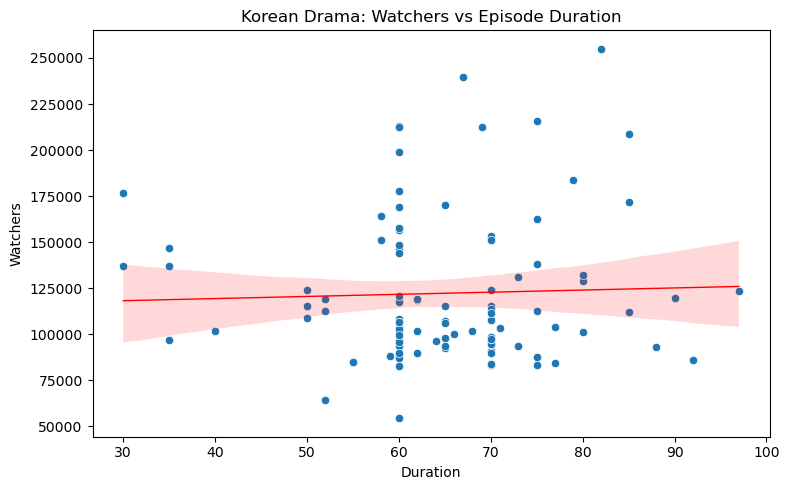

In [30]:
# Duration vs number of watchers scatterplot
plt.figure(figsize=(8, 5))
sns.scatterplot(data=df_duration_watchers, x='Duration', y='Watchers')
sns.regplot(data=df_duration_watchers, x='Duration', y='Watchers', scatter=False, color='red', line_kws={"linewidth": 1})
plt.title('Korean Drama: Watchers vs Episode Duration')
plt.xlabel('Duration')
plt.ylabel('Watchers')
plt.tight_layout()
plt.show()

In [31]:
# Correlation score: duration vs rating
corr_rating_duration, p_rating_duration = pearsonr(df_rating['Episodes'], df_rating['Rating'])
print(f'Rating correlation: {corr_rating_duration:.2f} (p = {p_rating_duration:.4f})')

# Correlation score: duration vs watchers
corr_watchers_duration, p_watchers_duration = pearsonr(df_watchers['Episodes'], df_watchers['Watchers'])
print(f"Watchers correlation: {corr_watchers_duration:.2f} (p = {p_watchers_duration:.4f})")

Rating correlation: -0.06 (p = 0.1872)
Watchers correlation: -0.08 (p = 0.2783)


* For both rating and number of watchers, there is negative correlation indicating that longer episode duration may lead to decrease in engagement
* The p-value shows that the number of duration of the episode does not have statistical signficance in rating and watchers

In [32]:
# Analyze tag popularity based on rating and watchers
df_tags = df[['Tags', 'Rating', 'Watchers']].dropna()
df_tags['Tags'] = df_tags['Tags'].str.lower().str.split(',')
df_tags = df_tags.explode('Tags')
df_tags['Tags'] = df_tags['Tags'].str.strip()

tag_stats = df_tags.groupby('Tags').agg(
    Avg_Rating=('Rating', 'mean'),
    Avg_Watchers=('Watchers', 'mean'),
    Count=('Tags', 'count')
).reset_index()

# Filter tags with at least 5 dramas
tag_stats = tag_stats[tag_stats['Count'] >= 5]

# Sort by rating or watchers
top_tags_by_rating = tag_stats.sort_values('Avg_Rating', ascending=False).head(15)
top_tags_by_watchers = tag_stats.sort_values('Avg_Watchers', ascending=False).head(15)

/var/folders/9d/qf8c_y4j6p92qbpr3js013zm0000gn/T/ipykernel_4015/3066374716.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_tags_by_rating, y='Tags', x='Avg_Rating', palette='viridis')


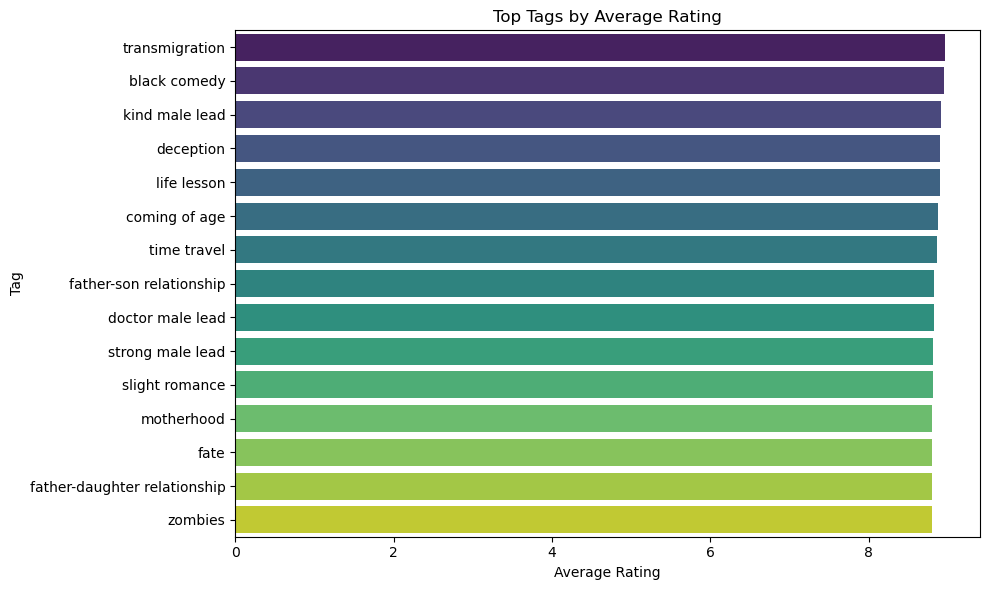

In [33]:
# Top tags by average rating
plt.figure(figsize=(10, 6))
sns.barplot(data=top_tags_by_rating, y='Tags', x='Avg_Rating', palette='viridis')
plt.title("Top Tags by Average Rating")
plt.xlabel("Average Rating")
plt.ylabel("Tag")
plt.tight_layout()
plt.show()

In [34]:
# ANOVA test for tags and rating
model_rating = ols('Rating ~C(Tags)', data=df_tags).fit()
anova_rating = sm.stats.anova_lm(model_rating, yp=2)
print("ANOVA: Rating ~ Tags")
print(anova_rating)

ANOVA: Rating ~ Tags
              df      sum_sq   mean_sq         F        PR(>F)
C(Tags)    653.0  133.604726  0.204601  1.798419  1.375002e-20
Residual  1566.0  178.159761  0.113767       NaN           NaN


/var/folders/9d/qf8c_y4j6p92qbpr3js013zm0000gn/T/ipykernel_4015/4065443118.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_tags_by_watchers, y='Tags', x='Avg_Watchers', palette='rocket')


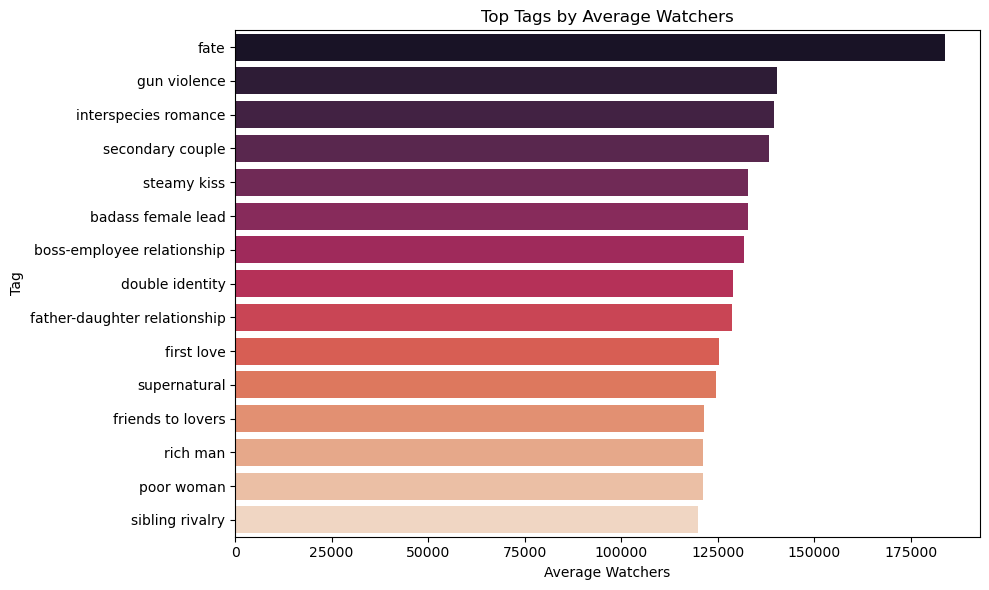

In [35]:
# Top tags by average watchers
plt.figure(figsize=(10, 6))
sns.barplot(data=top_tags_by_watchers, y='Tags', x='Avg_Watchers', palette='rocket')
plt.title("Top Tags by Average Watchers")
plt.xlabel("Average Watchers")
plt.ylabel("Tag")
plt.tight_layout()
plt.show()

In [36]:
# ANOVA test for tags and watchers
model_watchers = ols('Watchers ~ C(Tags)', data=df_tags).fit()
anova_watchers = sm.stats.anova_lm(model_watchers, typ=2)
print("\nANOVA: Watchers ~ Tags")
print(anova_watchers)


ANOVA: Watchers ~ Tags
                sum_sq      df         F        PR(>F)
C(Tags)   2.771733e+12   653.0  1.821003  2.051851e-21
Residual  3.650223e+12  1566.0       NaN           NaN


* Tags have statistical significance in both rating and watchers

/var/folders/9d/qf8c_y4j6p92qbpr3js013zm0000gn/T/ipykernel_4015/1395356739.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_top_tags, x='Rating', y='Tags', palette='Blues')


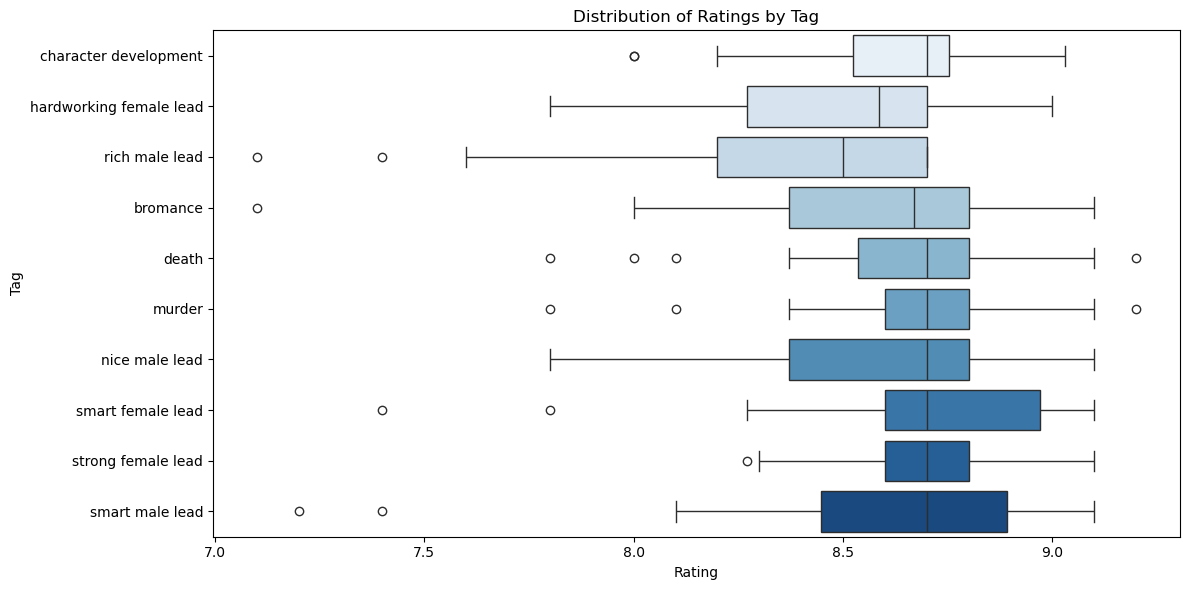

In [37]:
# Visualize distribution of rating and watchers for each tag using boxplot

# Top 10 tags by frequency
top_tags = df_tags['Tags'].value_counts().head(10).index
df_top_tags = df_tags[df_tags['Tags'].isin(top_tags)]

# Boxplot rating by tag
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_top_tags, x='Rating', y='Tags', palette='Blues')
plt.title('Distribution of Ratings by Tag')
plt.xlabel('Rating')
plt.ylabel('Tag')
plt.tight_layout()
plt.show()

## Distribution of Ratings by Tag
Top performing tags:
* "Smart male lead" tag has the highest median rating (close to 9.0) and high consistenty. There's almost no low outliers, showing that it is well-received
* "Strong female lead" lead also has strong rating (median ~8.8), but has slightly wider spread than smart male lead
* "Smart female lead" has high ratings and tight distribution (consistently well-liked)
* "Character development" has the highest ceiling and good consistency

Mid-tier tags
* "Rich male lead", "nice male lead" and "bromance" tags have median ratings in the 8.5-8.6 range
    * These tags have broader boxes, showing more variability in ratings. But overall, they're well-received
* "Murder" and "death" have low median (~8.4) and have broader spread. These tags also have more outliers, indicating that their themes are polarizing
* "Hardworking female lead" has wider range and slightly lower median. While it's generally well-received, there's more variability

/var/folders/9d/qf8c_y4j6p92qbpr3js013zm0000gn/T/ipykernel_4015/3409195122.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_top_tags, x='Watchers', y='Tags', palette='Oranges')


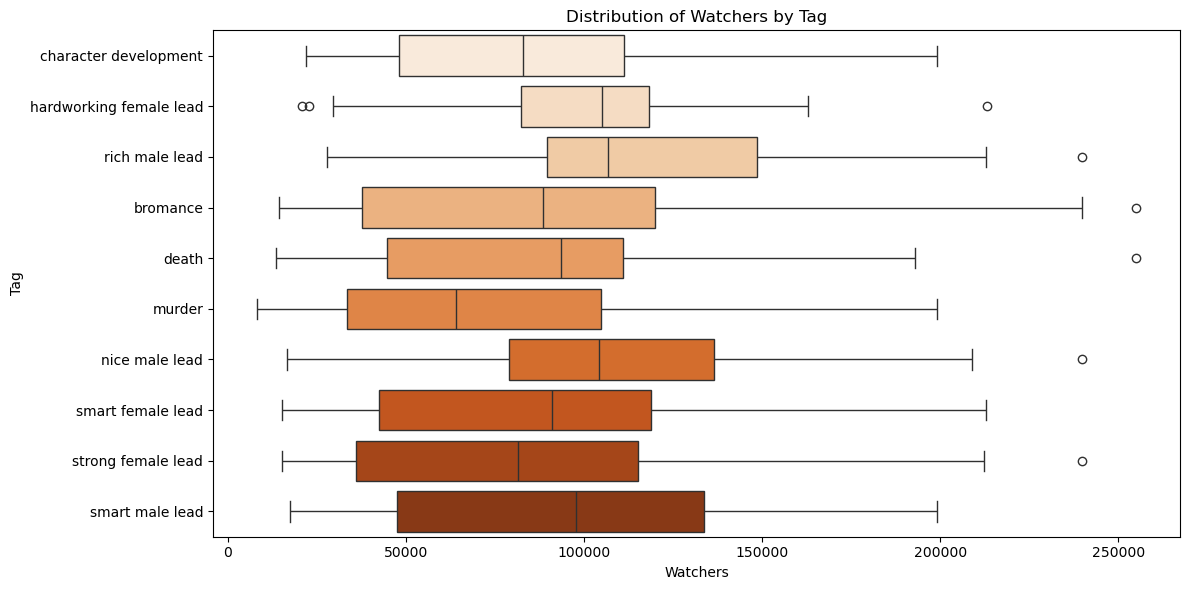

In [38]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_top_tags, x='Watchers', y='Tags', palette='Oranges')
plt.title('Distribution of Watchers by Tag')
plt.xlabel('Watchers')
plt.ylabel('Tag')
plt.tight_layout()
plt.show()

## Distribution of Watchers by Tag
* "Smart male lead", "strong female lead", and "smart female lead" show higher number of watchers on average
* "Character development" and "hardworking female lead" have lower number of watchers
* "Bromance" and "nice male lead" show greater spread in number of watchers, suggesting a wider range of popularity within those categories
* "Murder", "death" and "bromance" have a similar median number of watchers
* "Rich male lead" have slightly higher median number than "character development" and "hardworking female lead", but has a wider IQR indicating more variability

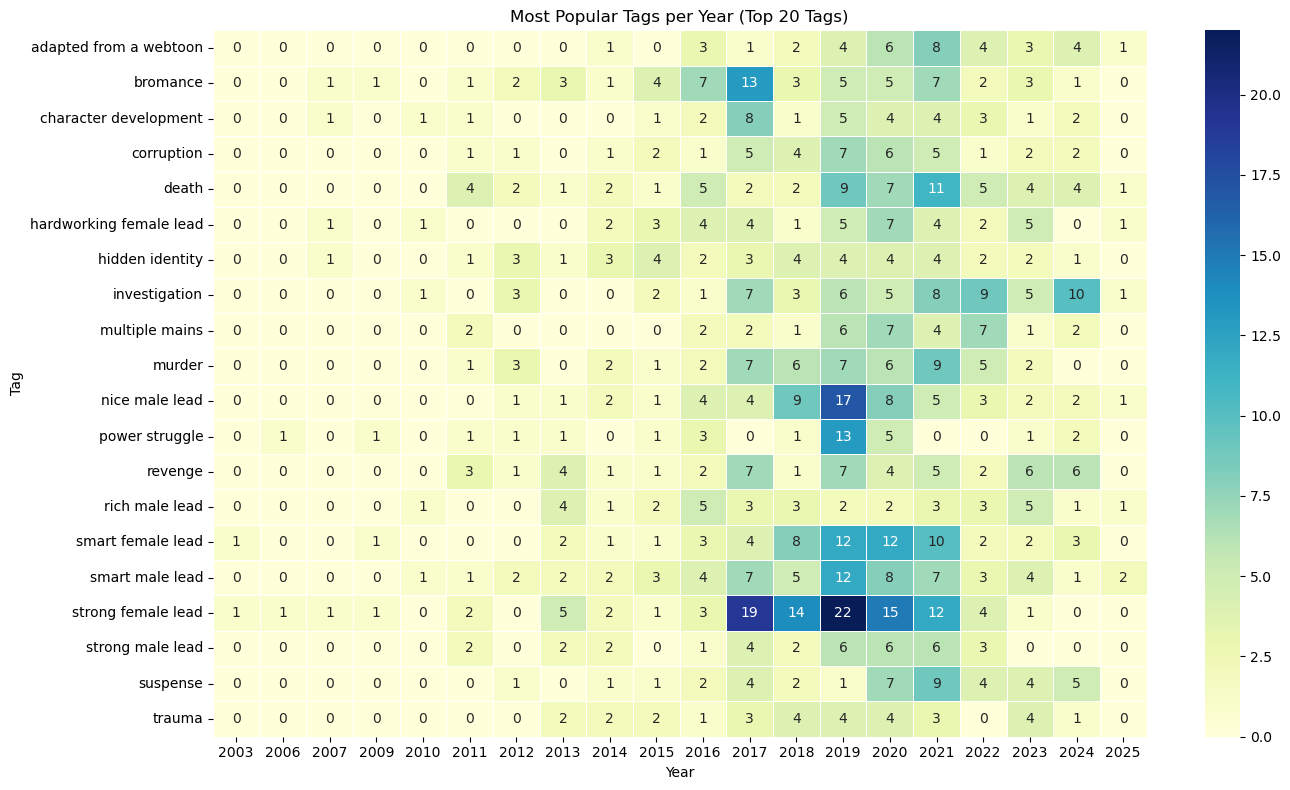

In [39]:
# Tag frequency analysis per year
df_tags_year = df[['Year', 'Tags']].dropna(subset=['Tags', 'Year'])

df_tags_year['Tags'] = df_tags_year['Tags'].str.lower().str.split(',')
df_tags_year = df_tags_year.explode('Tags')
df_tags_year['Tags'] = df_tags_year['Tags'].str.strip()

df_tags_year['Year'] = df_tags_year['Year'].astype(int)

tag_counts_year = df_tags_year.groupby(['Year', 'Tags']).size().reset_index(name='Count')
top_year_tags = tag_counts_year.groupby('Tags')['Count'].sum().sort_values(ascending=False).head(20).index 
tag_counts_year = tag_counts_year[tag_counts_year['Tags'].isin(top_year_tags)]
tag_pivot = tag_counts_year.pivot(index='Tags', columns='Year', values='Count').fillna(0)

# Plot Heatmap
plt.figure(figsize=(14, 8))
sns.heatmap(tag_pivot, annot=True, fmt='.0f', cmap='YlGnBu', linewidths=0.5)
plt.title('Most Popular Tags per Year (Top 20 Tags)')
plt.xlabel('Year')
plt.ylabel('Tag')
plt.tight_layout()
plt.show()

In [40]:
# Popular tag based on year 
df_tags_watchers = df[['Year', 'Tags', 'Watchers']].dropna()

df_tags_watchers['Tags'] = df_tags_watchers['Tags'].str.lower().str.split(',')
df_tags_watchers = df_tags_watchers.explode('Tags')
df_tags_watchers['Tags'] = df_tags_watchers['Tags'].str.strip()

# Group by year and tag, then sum watchers
grouped_tags_watchers = df_tags_watchers.groupby(['Year', 'Tags'])['Watchers'].sum().reset_index()

# Get the top tags for each year
top_tags_by_year = grouped_tags_watchers.sort_values(['Year', 'Watchers'], ascending=[True, False])
top_tags_watchers_year = top_tags_by_year.groupby('Year').first().reset_index()

print(top_tags_watchers_year)

      Year                      Tags   Watchers
0   2007.0       barista female lead   104033.0
1   2009.0             love triangle   263636.0
2   2010.0             love triangle   198660.0
3   2011.0      adapted from a manga    91101.0
4   2013.0            rich male lead   423280.0
5   2014.0           hidden identity   391362.0
6   2015.0             love triangle   315942.0
7   2016.0                  bromance   901174.0
8   2017.0            nice male lead   700204.0
9   2018.0  male chases female first   439940.0
10  2019.0            nice male lead  1053714.0
11  2020.0        strong female lead   730673.0
12  2021.0           smart male lead   477454.0
13  2022.0           school bullying   319374.0
14  2023.0   hardworking female lead   188629.0
15  2024.0       age gap [real life]    95003.0


In [41]:
# Test if year and tags has statistical significance in the number of watchers
df_tags_filtered = df.dropna(subset=['Year', 'Tags', 'Watchers'])

df_tags_filtered = df_tags_filtered.copy()
df_tags_filtered['Tags'] = df_tags_filtered['Tags'].str.lower().str.split(',')
df_tags_filtered = df_tags_filtered.explode('Tags')
df_tags_filtered['Tags'] = df_tags_filtered['Tags'].str.strip()
df_tags_filtered['Year'] = df_tags_filtered['Year'].astype(int)

top_tags = df_tags_filtered['Tags'].value_counts().head(15).index
df_tags_filtered = df_tags_filtered[df_tags_filtered['Tags'].isin(top_tags)]

# Run Two-Way ANOVA
tags_model = ols('Watchers ~ C(Year) + C(Tags) + C(Year):C(Tags)', data=df_tags_filtered).fit()
tags_anova_table = sm.stats.anova_lm(tags_model, typ=2)
print(tags_anova_table)

                       sum_sq     df         F    PR(>F)
C(Year)         -7.306937e+09   14.0 -0.219151  1.000000
C(Tags)          1.879273e+10   14.0  0.563635  0.825268
C(Year):C(Tags)  2.280192e+11  196.0  0.488485  0.999986
Residual         3.762889e+11  158.0       NaN       NaN


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 14, but rank is 10
  warnings.warn('covariance of constraints does not have full '
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 14, but rank is 9
  warnings.warn('covariance of constraints does not have full '
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 196, but rank is 131
  warnings.warn('covariance of constraints does not have full '


Looking at PR(>F) values, there is no statistical significance of year and tags in the number of watchers since it's greater than 0.05 

/var/folders/9d/qf8c_y4j6p92qbpr3js013zm0000gn/T/ipykernel_4015/3405268463.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cast_counts.values, y=cast_counts.index, palette='coolwarm')


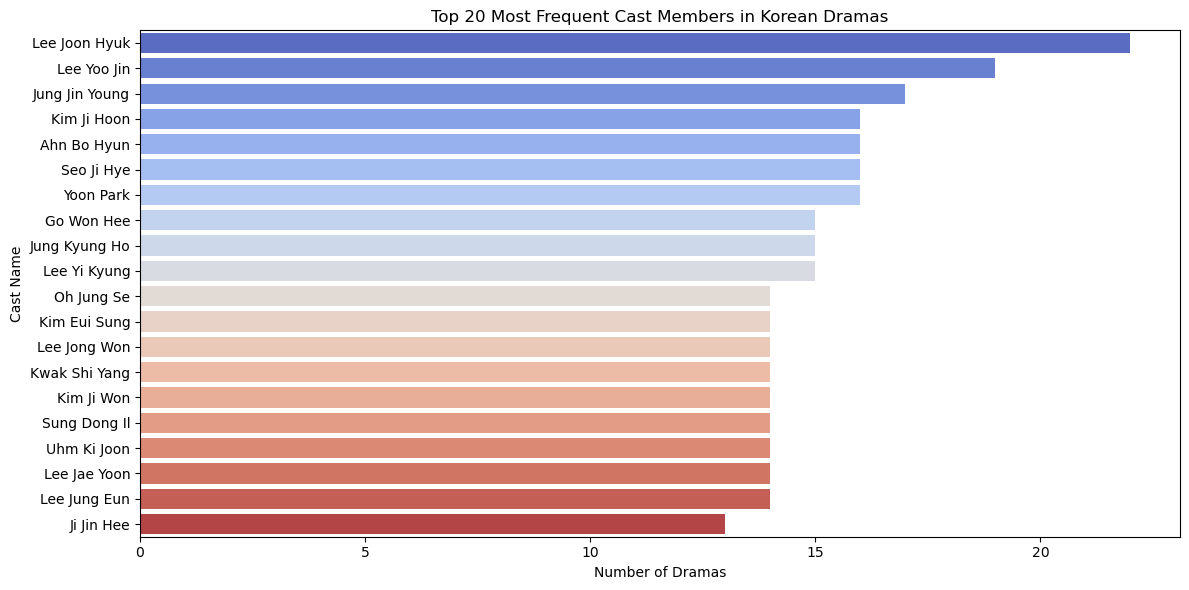

In [42]:
# Most frequent cast names
cast_data = df['Cast'].dropna()

# Split by comma and flatten into one list
all_cast = cast_data.str.split(',').explode().str.strip()

# Count frequencies
cast_counts = all_cast.value_counts().head(20)

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(x=cast_counts.values, y=cast_counts.index, palette='coolwarm')
plt.xlabel('Number of Dramas')
plt.ylabel('Cast Name')
plt.title('Top 20 Most Frequent Cast Members in Korean Dramas')
plt.tight_layout()
plt.show()

/var/folders/9d/qf8c_y4j6p92qbpr3js013zm0000gn/T/ipykernel_4015/391801600.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_genres_cast['Genres'] = df_genres_cast['Genres'].str.lower().str.split(',')
/var/folders/9d/qf8c_y4j6p92qbpr3js013zm0000gn/T/ipykernel_4015/391801600.py:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_cast_per_genre = genre_cast_counts.groupby('Genres').apply(lambda g: g.sort_values(by='Count', ascending=False).head(10)).res

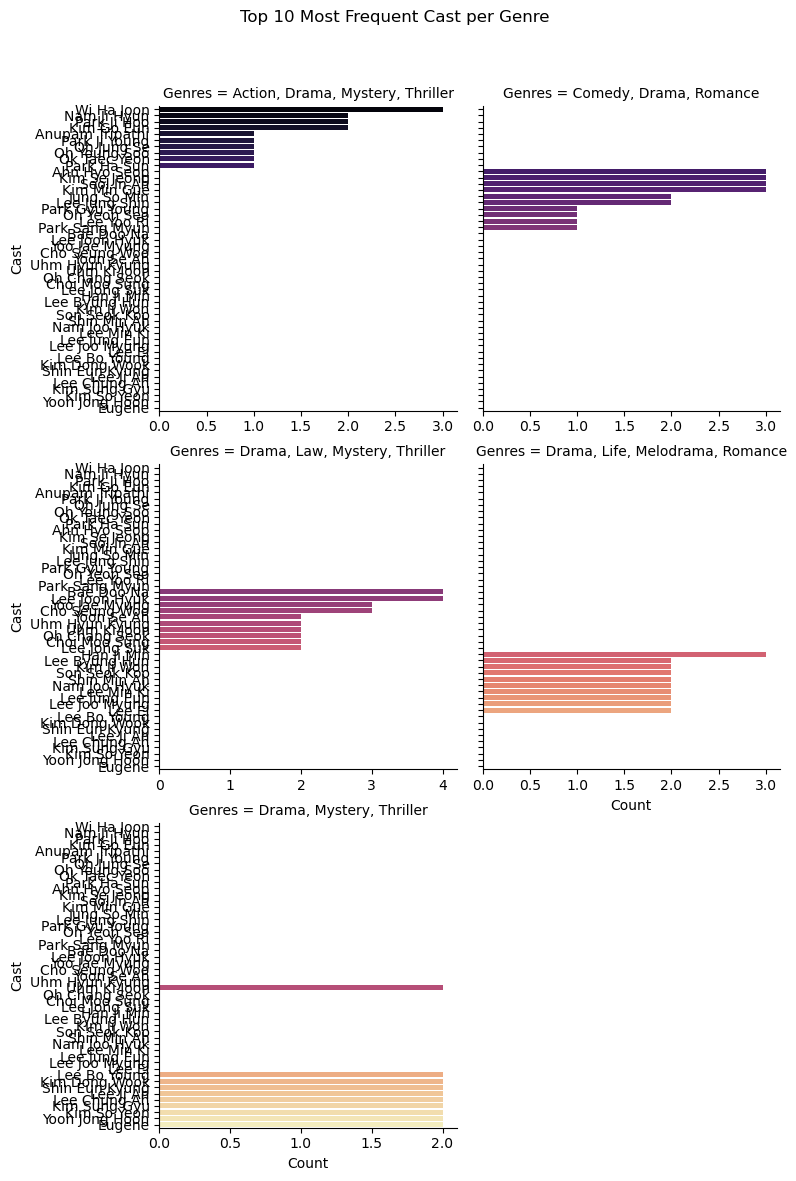

In [43]:
# Most frequent cast names based on genre

df_genres_cast = df.dropna(subset=['Genres', 'Cast'])
df_genres_cast['Genres'] = df_genres_cast['Genres'].str.lower().str.split(',')
df_genres_cast = df_genres_cast.explode('Genres')
df_genres_cast['Genres'] = df_genres_cast['Genres'].str.strip()

# Filter top genres
top_genres = df['Genres'].value_counts().head(5).index.tolist()
df_top_genres = df[df['Genres'].isin(top_genres)]

# Explode cast
df_top_genres_cast = df_top_genres.copy()
df_top_genres_cast['Cast'] = df_top_genres_cast['Cast'].str.split(',')
df_top_genres_cast = df_top_genres_cast.explode('Cast')
df_top_genres_cast['Cast'] = df_top_genres_cast['Cast'].str.strip()

# Count top 10 cast in each genre
genre_cast_counts = (df_top_genres_cast.groupby(['Genres', 'Cast']).size().reset_index(name='Count'))

# Top 10 per genre
top_cast_per_genre = genre_cast_counts.groupby('Genres').apply(lambda g: g.sort_values(by='Count', ascending=False).head(10)).reset_index(drop=True)

# Plot
g = sns.catplot(
    data=top_cast_per_genre,
    x='Count', y='Cast',
    col='Genres',
    kind='bar',
    col_wrap=2,
    height=4,
    sharex=False,
    palette='magma'
)

g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Top 10 Most Frequent Cast per Genre')
plt.show()

In [44]:
# Cast member vs genre using chi-square test
df_cast_genre = df[['Genres', 'Cast']].dropna()
df_cast_genre['Genres'] = df_cast_genre['Genres'].str.lower().str.split(',')
df_cast_genre['Cast'] = df_cast_genre['Cast'].str.split(',')

df_cast_genre = df_cast_genre.explode('Genres')
df_cast_genre = df_cast_genre.explode('Cast')

df_cast_genre['Genres'] = df_cast_genre['Genres'].str.strip()
df_cast_genre['Cast'] = df_cast_genre['Cast'].str.strip()

top_genres = df_cast_genre['Genres'].value_counts().head(5).index
top_cast_genres = df_cast_genre['Cast'].value_counts().head(10).index 

df_subset = df_cast_genre[df_cast_genre['Genres'].isin(top_genres) & df_cast_genre['Cast'].isin(top_cast_genres)]

contingency_table = pd.crosstab(df_subset['Cast'], df_subset['Genres'])

chi2, p, dof, expected = chi2_contingency(contingency_table)
print(f"Chi-square: {chi2:.2f}, p-value: {p:.4f}")

Chi-square: 67.10, p-value: 0.0013


For popular genres, there is statitiscal significance of the cast

/var/folders/9d/qf8c_y4j6p92qbpr3js013zm0000gn/T/ipykernel_4015/1935565073.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_watchers_cast['Cast'] = df_watchers_cast['Cast'].str.split(',')
/var/folders/9d/qf8c_y4j6p92qbpr3js013zm0000gn/T/ipykernel_4015/1935565073.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_watch_cast.values, y=top_watch_cast.index, palette='viridis')


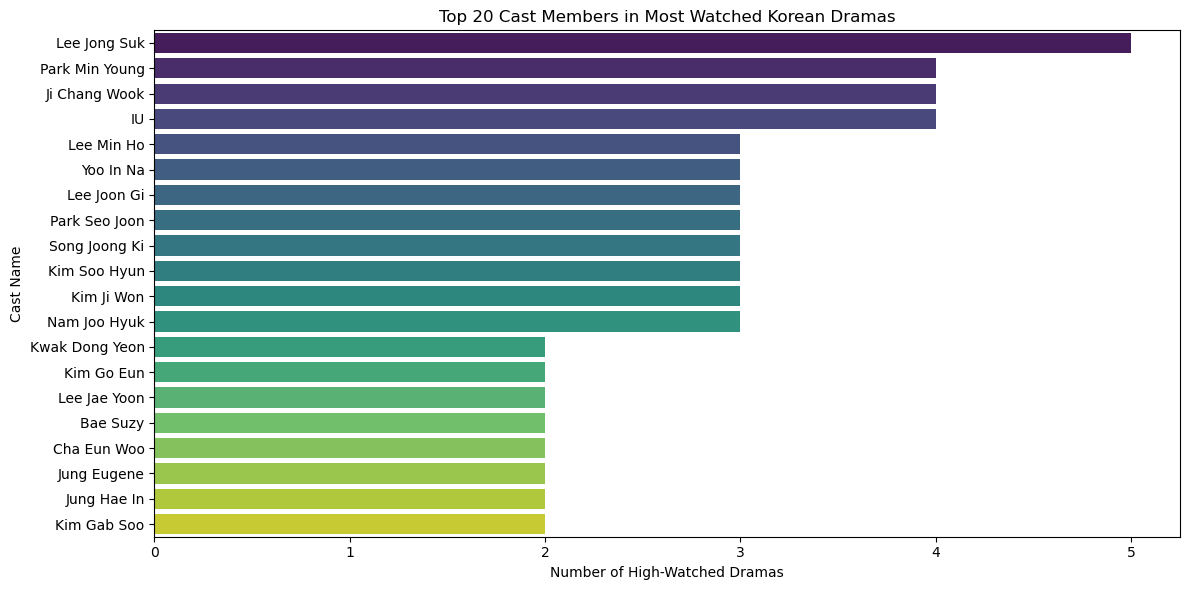

In [45]:
# Top 20 cast vs number of watchers

# Threshold - top 25% of number of watchers
watcher_threshold = df['Watchers'].quantile(0.75)

# Filter dramas with high number of watchers and cast
df_watchers_cast = df[(df['Watchers'] >= watcher_threshold) & (df['Cast'].notna())]

# Explode cast
df_watchers_cast['Cast'] = df_watchers_cast['Cast'].str.split(',')
df_watchers_cast = df_watchers_cast.explode('Cast')
df_watchers_cast['Cast'] = df_watchers_cast['Cast'].str.strip()

# Count top 20
top_watch_cast = df_watchers_cast['Cast'].value_counts().head(20)

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(x=top_watch_cast.values, y=top_watch_cast.index, palette='viridis')
plt.xlabel('Number of High-Watched Dramas')
plt.ylabel('Cast Name')
plt.title('Top 20 Cast Members in Most Watched Korean Dramas')
plt.tight_layout()
plt.show()

In [46]:
# Test statistical significance of cast vs watchers using one-way ANOVA

df_cast_watch = df[['Cast', 'Watchers']].dropna()

df_cast_watch['Cast'] = df_cast_watch['Cast'].str.split(',')
df_cast_watch = df_cast_watch.explode('Cast')
df_cast_watch['Cast'] = df_cast_watch['Cast'].str.strip()

top_cast = df_cast_watch['Cast'].value_counts().head(15).index
df_cast_watch = df_cast_watch[df_cast_watch['Cast'].isin(top_cast)]

model = ols('Watchers ~ C(Cast)', data=df_cast_watch).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

                sum_sq    df         F    PR(>F)
C(Cast)   7.980883e+10  14.0  2.275953  0.011003
Residual  2.078919e+11  83.0       NaN       NaN


For number of watchers, there is statistical significance of the cast. This makes sense as most of the popular Korean dramas cast top actors/actresses

/var/folders/9d/qf8c_y4j6p92qbpr3js013zm0000gn/T/ipykernel_4015/1682422180.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_ratings.values, y=avg_ratings.index, palette='crest')


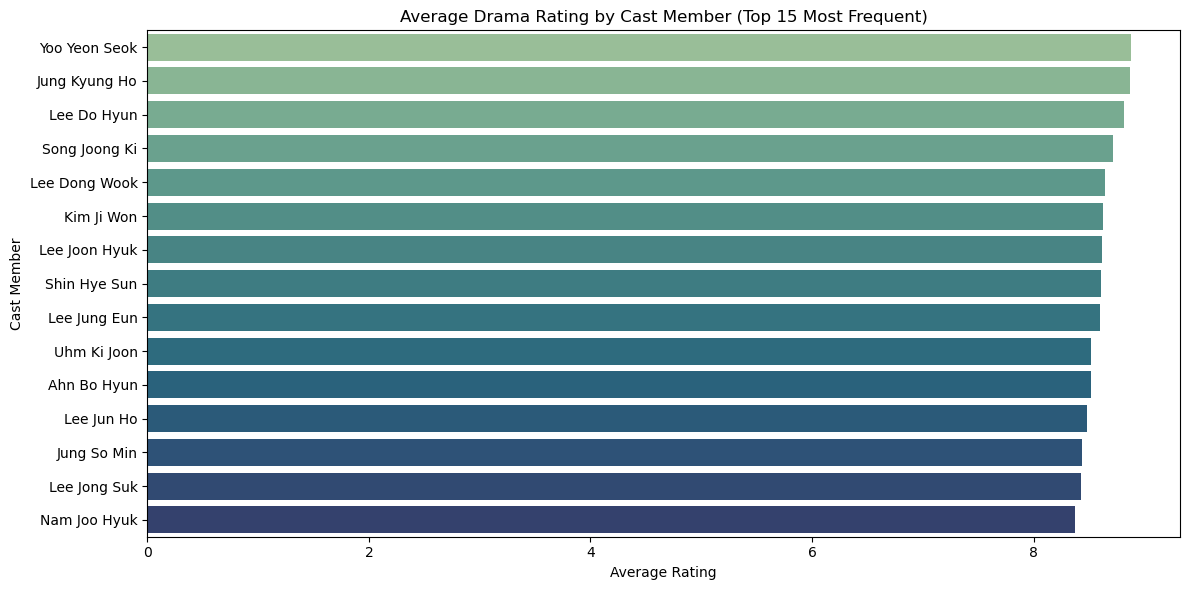

In [47]:
# Top cast by rating

df_cast_rating = df[['Rating', 'Cast']].dropna()

# Split and explode cast
df_cast_rating['Cast'] = df_cast_rating['Cast'].str.split(',')
df_cast_rating = df_cast_rating.explode('Cast')
df_cast_rating['Cast'] = df_cast_rating['Cast'].str.strip()

# Optional: Limit to top 15 most frequent cast members
top_cast = df_cast_rating['Cast'].value_counts().head(15).index
df_cast_rating = df_cast_rating[df_cast_rating['Cast'].isin(top_cast)]

# Compute average rating per cast
avg_ratings = df_cast_rating.groupby('Cast')['Rating'].mean().sort_values(ascending=False)

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(x=avg_ratings.values, y=avg_ratings.index, palette='crest')
plt.xlabel('Average Rating')
plt.ylabel('Cast Member')
plt.title('Average Drama Rating by Cast Member (Top 15 Most Frequent)')
plt.tight_layout()
plt.show()

In [48]:
# Test statistical significance of cast and average rating
model = ols('Rating ~ C(Cast)', data=df_cast_rating).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

             sum_sq     df         F    PR(>F)
C(Cast)    3.383787   14.0  2.897197  0.000751
Residual  11.095545  133.0       NaN       NaN


Ratings differ signficantly by cast

/var/folders/9d/qf8c_y4j6p92qbpr3js013zm0000gn/T/ipykernel_4015/2133605205.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tags_cast['Tags'] = df_tags_cast['Tags'].str.lower().str.split(',')
/var/folders/9d/qf8c_y4j6p92qbpr3js013zm0000gn/T/ipykernel_4015/2133605205.py:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_cast_per_tag = tags_cast_count.groupby('Tags').apply(lambda g: g.sort_values(by='Count', ascending=False).head(10)).reset_index(dro

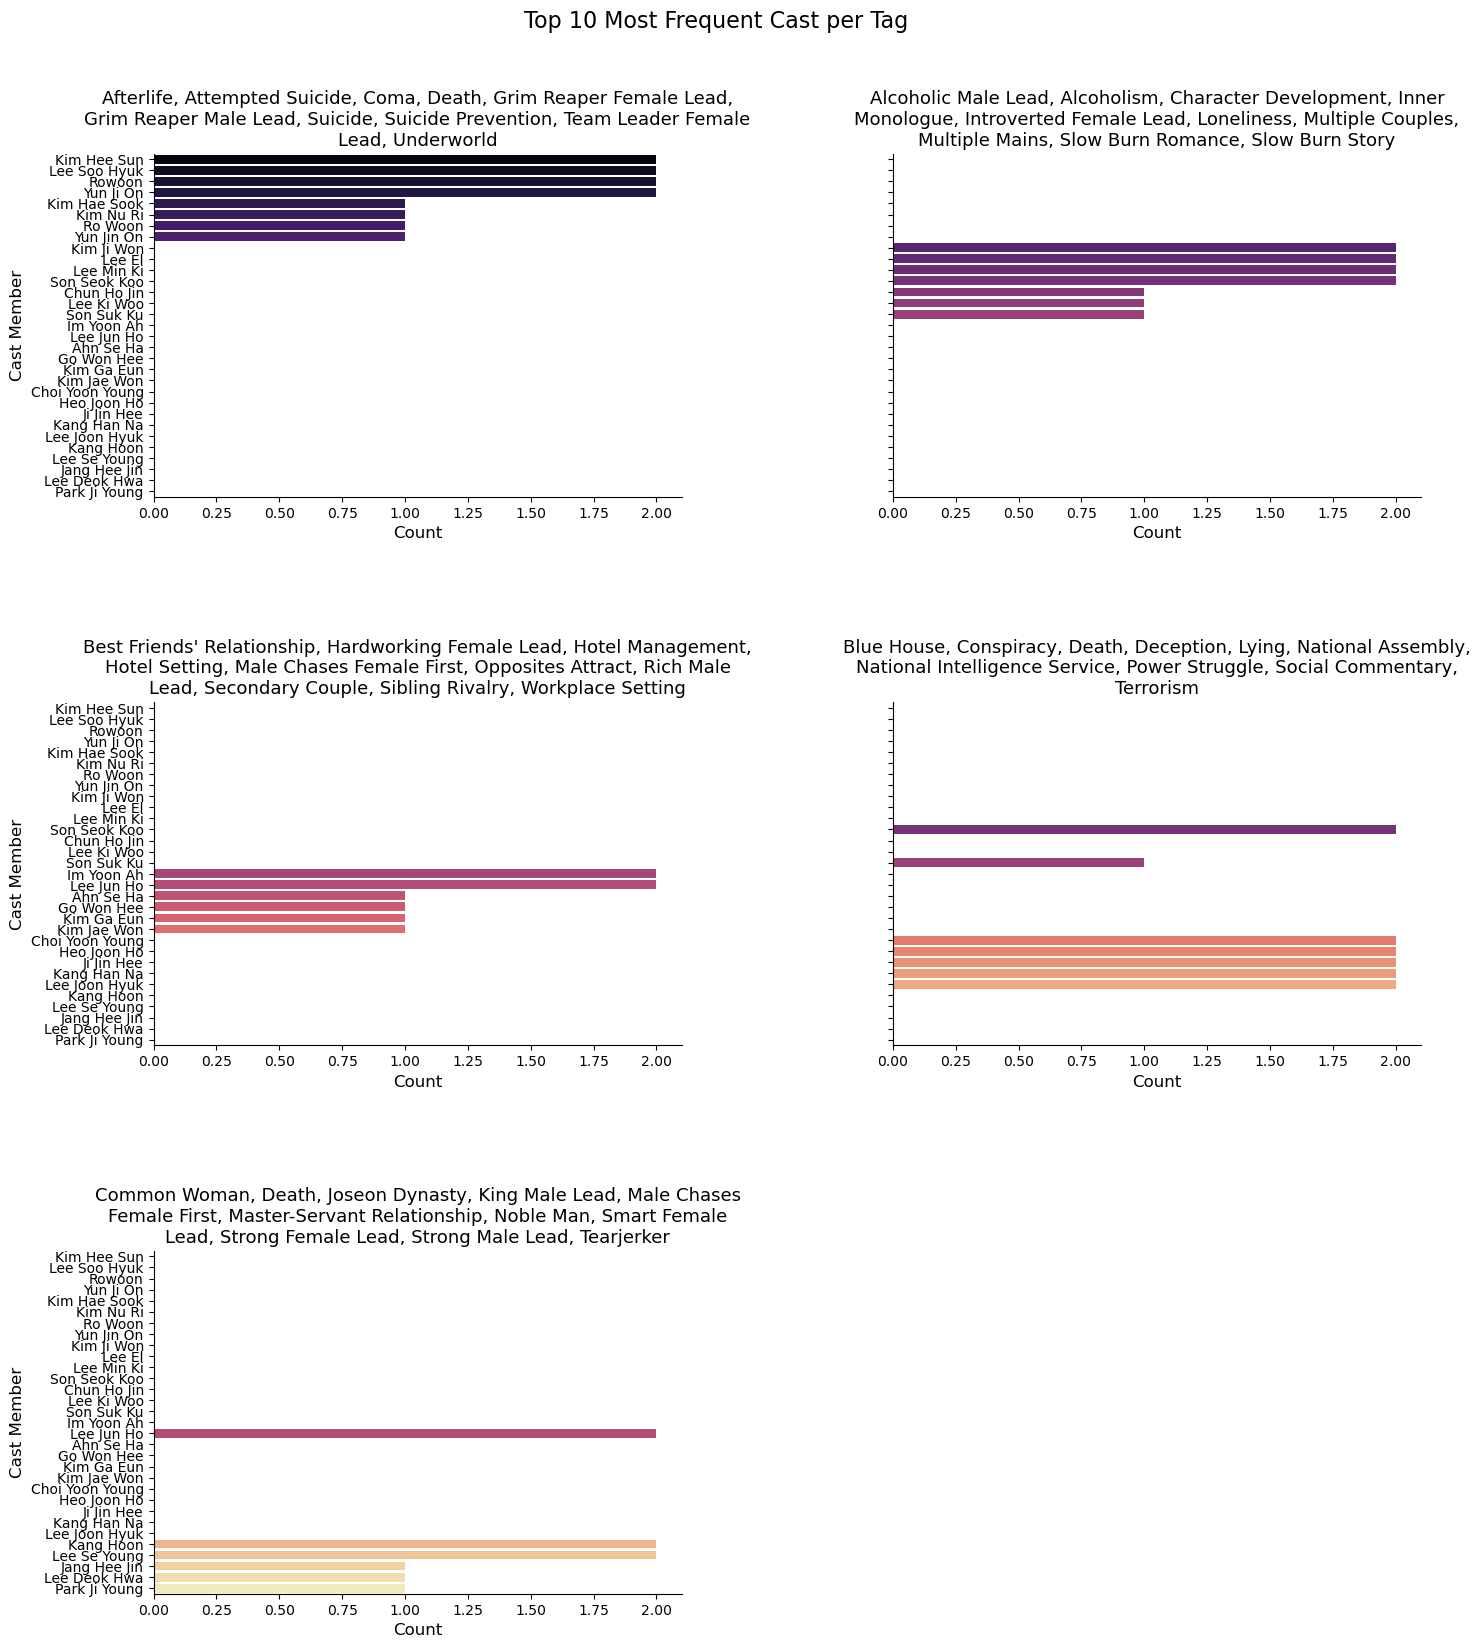

In [49]:
# Most frequent cast names based on tags

df_tags_cast = df.dropna(subset=['Tags', 'Cast'])
df_tags_cast['Tags'] = df_tags_cast['Tags'].str.lower().str.split(',')
df_tags_cast = df_tags_cast.explode('Tags')
df_tags_cast['Tags'] = df_tags_cast['Tags'].str.strip()

# Filter top genres
top_tags_cast = df['Tags'].value_counts().head(5).index.tolist()
dt_top_tags = df[df['Tags'].isin(top_tags_cast)]

# Explode cast
df_top_tags_cast = dt_top_tags.copy()
df_top_tags_cast['Cast'] = df_top_tags_cast['Cast'].str.split(',')
df_top_tags_cast = df_top_tags_cast.explode('Cast')
df_top_tags_cast['Cast'] = df_top_tags_cast['Cast'].str.strip()

# Count top 10 cast in each genre
tags_cast_count = (df_top_tags_cast.groupby(['Tags', 'Cast']).size().reset_index(name='Count'))

# Top 10 per genre
top_cast_per_tag = tags_cast_count.groupby('Tags').apply(lambda g: g.sort_values(by='Count', ascending=False).head(10)).reset_index(drop=True)

# Plot
g = sns.catplot(
    data=top_cast_per_tag,
    x='Count',
    y='Cast',
    col='Tags',
    kind='bar',
    col_wrap=2,
    height=6,         # Increase height
    aspect=1.2,       # Make it wider
    sharex=False,
    palette='magma'
)

# Create some space between subplots
g.fig.subplots_adjust(top=0.88, bottom=0.1, hspace=0.6, wspace=0.4)
g.fig.suptitle('Top 10 Most Frequent Cast per Tag', fontsize=16)

# Rotate labels and set font size
for ax in g.axes.flat:
    raw_title = ax.get_title().replace("Tags = ", "")
    wrapped = '\n'.join(textwrap.wrap(raw_title, width=70))  # wrap long titles
    ax.set_title(wrapped, fontsize=13)
    ax.set_ylabel("Cast Member", fontsize=12)
    ax.set_xlabel("Count", fontsize=12)
    ax.tick_params(axis='y', labelsize=10)  # Make y labels smaller
    ax.tick_params(axis='x', labelsize=10)

# Title formatting
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Top 10 Most Frequent Cast per Tag', fontsize=16)

plt.show()

In [50]:
# Cast member vs tag using chi-square test
top_tags = df_tags_cast['Tags'].value_counts().head(5).index.tolist()
top_cast = df_tags_cast['Cast'].value_counts().head(10).index.tolist()

df_cast_tag_subset = df_tags_cast[df_tags_cast['Tags'].isin(top_tags) & df_tags_cast['Cast'].isin(top_cast)]

contingency_table = pd.crosstab(df_cast_tag_subset['Cast'], df_cast_tag_subset['Tags'])

chi2, p, dof, expected = chi2_contingency(contingency_table)
print(f"Chi-square: {chi2:.2f}, p-value: {p:.4f}")

Chi-square: 46.16, p-value: 0.0168


Tags differ significantly by cast

In [51]:
# Run chi-square test if certain combinations of genre + tags have statistical significance

# Create combined category
df_tags_cast['GenreTag'] = df_tags_cast['Genres'] + " | " + df_tags_cast['Tags']

# Filter again for top items
top_genretags = df_tags_cast['GenreTag'].value_counts().head(10).index
top_cast = df_tags_cast['Cast'].value_counts().head(10).index

df_gtc_subset = df_tags_cast[
    df_tags_cast['GenreTag'].isin(top_genretags) &
    df_tags_cast['Cast'].isin(top_cast)
]

# Create contingency table
table = pd.crosstab(df_gtc_subset['Cast'], df_gtc_subset['GenreTag'])

# Run chi-square test
chi2, p, dof, expected = chi2_contingency(table)
print(f"Chi-square: {chi2:.2f}, p-value: {p:.4f}")

Chi-square: 0.00, p-value: 1.0000


No statistical significance between cast with specific combinations of genre and tag
* Every cast may appear equally often across genre and tag combinations

## Popularity
* Build popularity metric for Korean dramas using rating and watchers
    * Create composite score using normalized rating and watchers with PCA-based weighting
    * Validate with Pearson correlation

In [52]:
drama_cols = ['Rating', 'Watchers']
drama_df = df.dropna(subset=drama_cols).copy()

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(drama_df[drama_cols])
pca = PCA(n_components=1)
pca.fit(X_scaled)
weights = pca.components_[0]
normalized_weights = weights / weights.sum()

rating_weight, watchers_weight = normalized_weights

drama_df['Popularity'] = (
    rating_weight * X_scaled[:, 0] +
    watchers_weight * X_scaled[:, 1]
)

drama_df['Popularity'] = drama_df['Popularity'].round(3)

for col in drama_cols:
    corr, p = pearsonr(drama_df['Popularity'], drama_df[col])
    print(f"Correlation with {col}: {corr:.3f} (p = {p:.2e})")

Correlation with Rating: -0.467 (p = 5.24e-12)
Correlation with Watchers: 0.947 (p = 6.99e-98)


In [53]:
drama_cols = ['Rating', 'Watchers']
df_drama_clean = df.dropna(subset=drama_cols).copy()
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(df_drama_clean[drama_cols])
pca = PCA(n_components=1)
pc1_scores = pca.fit_transform(X_scaled).flatten()

# Get explained variance and loadings
explained_variance = pca.explained_variance_ratio_
loadings = pd.DataFrame(
    pca.components_.T,
    columns=[f"PC{i+1}" for i in range(pca.n_components_)],
    index=drama_cols
)
print("Explained Variance:", explained_variance)
print("\nPCA Loadings:\n", loadings.round(3))

Explained Variance: [0.6096845]

PCA Loadings:
             PC1
Rating   -0.389
Watchers  0.921


In [54]:
# Raw PC1 loadings
pc1_loadings = {
    'Rating': -0.389,
    'Watchers': 0.921
}

# Remove low-impact variables (e.g., absolute loading < 0.1)
filtered = {k: abs(v) for k, v in pc1_loadings.items() if abs(v) > 0.1}

# Normalize
total = sum(filtered.values())
weights = {k: v / total for k, v in filtered.items()}
print("Normalized Weights (based on PCA PC1):")
for k, v in weights.items():
    print(f"{k}: {v:.2f}")

Normalized Weights (based on PCA PC1):
Rating: 0.30
Watchers: 0.70


In [62]:
drama_df['Popularity'] = (
    0.30 * drama_df['Rating'] +
    0.70 * drama_df['Watchers']
)

# Check pearson correlation with Watchers and Rating
for col in ['Watchers', 'Rating']:
    corr, pval = pearsonr(drama_df['Popularity'], drama_df[col])
    print(f"Correlation with {col}: {corr:.4f} (p-value: {pval:.2e})")

Correlation with Watchers: 1.0000 (p-value: 0.00e+00)
Correlation with Rating: -0.1592 (p-value: 2.59e-02)


In [65]:
# Drop rows with missing values in the required columns
popularity_cols = ['Rating', 'Watchers']
df_drama_clean = drama_df.dropna(subset=popularity_cols).copy()
drama_df.loc[df_drama_clean.index, 'Popularity'] = df_drama_clean['Popularity']
desired_order = ['Title', 'Rating', 'Genres', 'Tags', 'Watchers', 'Popularity', 'Cast', 'Synopsis']
drama_df['Popularity'] = drama_df['Popularity'].round(3)
drama_combined_clean = df.dropna(subset=desired_order).reset_index(drop=True)
drama_combined_clean = drama_combined_clean[desired_order] 

KeyError: ['Popularity']

In [ ]:
print("Before:", len(drama_combined))
print('After :', len(drama_combined_clean))
drama_combined_clean

Before: 1977
After : 182


,Title,Rating,Genres,Tags,Watchers,Popularity,Cast,Synopsis
0,18 Again,8.67,"Drama, Fantasy, Life, Romance","Becoming Young, Character Development, Divorce...",83582.0,-0.034,"Kim Ha Neul, Lee Do Hyun, Roh Jeong Eui, Ryeou...","After nearly twenty years of marriage, Jung Da..."
1,A Business Proposal,8.70,"Comedy, Drama, Romance","Blind Date, Boss-Employee Relationship, Cheerf...",99264.0,0.018,"Ahn Hyo Seop, Kim Min Gue, Kim Se Jeong, Seol ...",Shin Ha Ri is a single woman and works for a c...
2,A Korean Odyssey,8.27,"Comedy, Fantasy, Horror, Romance","Adapted From A Novel, Aggressive Male Lead, Br...",101149.0,0.105,"Cha Seung Won, Jang Gwang, Lee El, Lee Hong Ki...","In 2017, Son Oh Gong and Ma Wang are in confli..."
3,Abyss,7.80,"Comedy, Fantasy, Mystery, Romance","Age Gap [Real Life], Death, Hardworking Female...",100611.0,0.190,"Ahn Hyo Seop, Han So Hee, Kwon Soo Hyun, Lee S...",“Abyss” is about a man and a woman who tragica...
4,Alchemy of Souls,9.03,"Action, Fantasy, Historical, Romance","Apprentice, Body Swap, Comedy, Disciple Relati...",129020.0,0.067,"Hwang Hyun Min, Hwang Min Hyun, Jung So Min, L...",Set in a fictional country called Daeho that d...
...,...,...,...,...,...,...,...,...
177,What's Wrong with Secretary Kim,8.50,"Business, Comedy, Friendship, Romance","Adapted From A Webtoon, Boss-Employee Relation...",212766.0,0.473,"Kim Byung Ok, Kim Hye Ok, Lee Tae Hwan, Park M...",The series revolves around the narcissistic Le...
178,While You Were Sleeping,8.70,"Drama, Fantasy, Mystery, Romance, Supernatural","Cheerful Male Lead, Childhood Acquaintance, Co...",176827.0,0.304,"Bae Suzy, Hwang Young Hee, Jung Hae In, Lee Jo...",A young woman with bad premonition dreams meet...
179,While You Were Sleeping,8.70,"Drama, Fantasy, Mystery, Romance","Childhood Acquaintance, First Love, Healing, M...",136482.0,0.155,"Bae Suzy, Jung Hae In, Lee Jong Suk, Lee Sang ...",A young woman with bad premonition dreams meet...
180,Who Are You: School 2015,8.20,"Drama, Mystery, Romance, Youth","Amnesia, Hidden Identity, High School, Identit...",89619.0,0.075,"Jo Soo Hyang, Kim Hee Jung, Kim So Hyun, Lee P...",Sekang High School is the most prestigious pri...


In [ ]:
drama_combined_clean.to_csv("data/combined/clean/drama_combined_clean.csv", index=False)